<a href="https://colab.research.google.com/github/mohamedSalehMatar/EnhancedTemplateMatcher/blob/main/EnhancedTemplateMatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import cv2
import numpy as np
from scipy import ndimage
from google.colab.patches import cv2_imshow
from google.colab import files

In [10]:
# The function works the same as range() function in Python but with float numbers
def frange(start, end, step):
    current = start
    while current < end:
        yield current
        current += step

In [11]:
# Difining the global variable needed
best_match = None
best_val = -1
best_scale = 0.0
best_angle = 0.0

Upload the template image:


Saving coin.PNG to coin.PNG


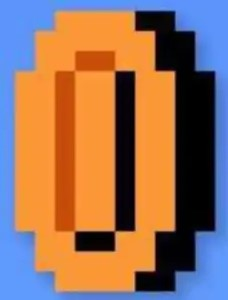

In [12]:
# Upload the template image and gray-scaling it

print("Upload the template image:")
uploaded = files.upload()
template_filename = list(uploaded.keys())[0]
t = cv2.imdecode(np.frombuffer(uploaded[template_filename], np.uint8), cv2.IMREAD_UNCHANGED)
tg = cv2.cvtColor(t, cv2.COLOR_BGR2GRAY)
cv2_imshow(t)

# Taking the height and width of the template image
h = tg.shape[0]
w = tg.shape[1]


Upload the main image:


Saving mario180.PNG to mario180.PNG


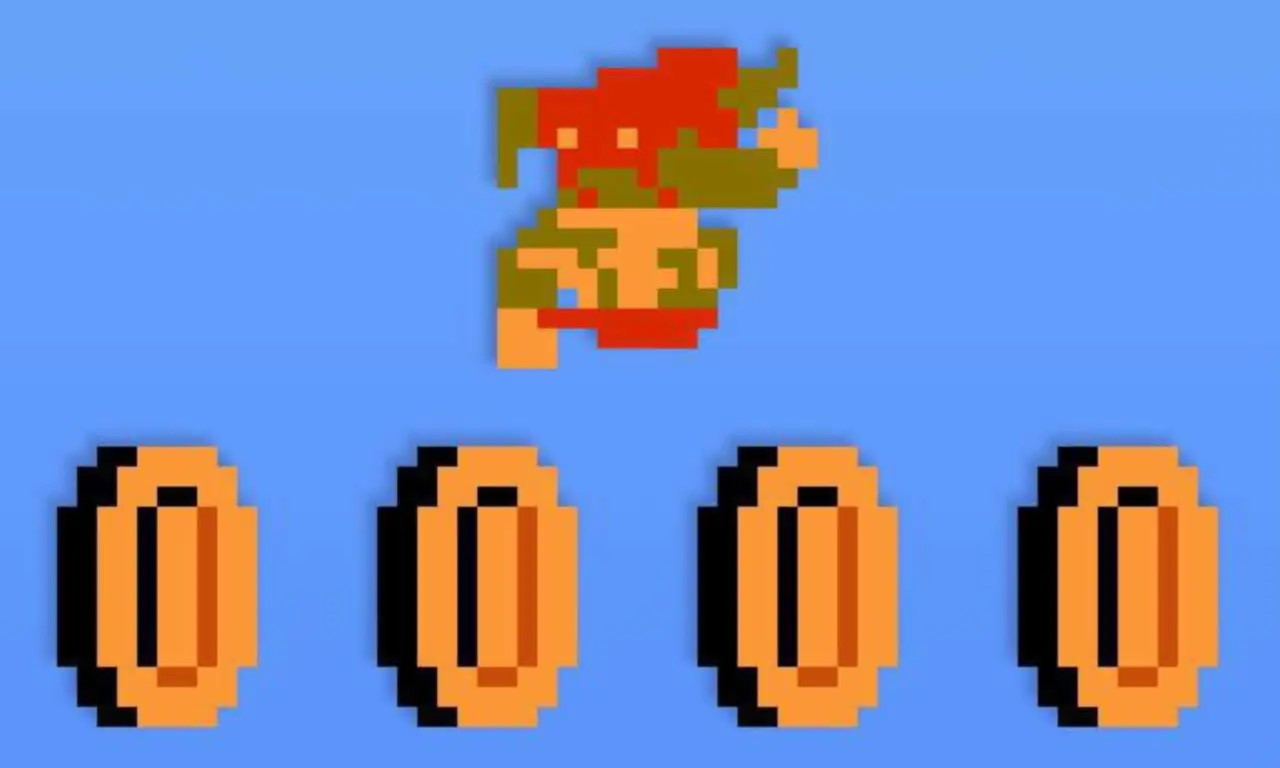

In [13]:
# Loading the main image and gray-scaling it

print("Upload the main image:")
uploaded = files.upload()
main_filename = list(uploaded.keys())[0]
m = cv2.imdecode(np.frombuffer(uploaded[main_filename], np.uint8), cv2.IMREAD_UNCHANGED)
mg = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)
cv2_imshow(m)

In [14]:
# A nested for loop the examine all possible template cases to find any possible match

# The outer loop interate on the specifyed scale range
# Narrowing the scale range lowers the run time but also accuracy
for scale in frange(1, 100, 0.5):
    print("Scale = ", scale)

    # Resize the template to the specifyed scale
    resized_template = cv2.resize(tg, (int(w * scale), int(h * scale)))

    # Checking if the new size of template is less than size of the main image
    if resized_template.shape > mg.shape:
        break

    # The inner loop interate on the specifyed angle range
    # Narrowing the angle range lowers the run time but also accuracy
    for angle in frange(0, 360, 10):
        print("Angle = ", angle)

        # Rotate the resized template to the specifyed angle
        rotated_template = ndimage.rotate(resized_template, angle)

        # Checking if the new rotation of template made the width or height exceed the width or height of the main image
        if rotated_template.shape[0] > mg.shape[0] or rotated_template.shape[1] > mg.shape[1]:
            break

        # Ready made function to compare the template to main image
        result = cv2.matchTemplate(mg, rotated_template, cv2.TM_CCOEFF_NORMED)

        # Ready made function to extract the main values resulted from the template matching
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        print(">", max_val)

        # If the score is above the threshold, a match is found
        if max_val > best_val:
            best_val = max_val
            best_match = max_loc
            best_scale = scale
            best_angle = angle
            print("==>>", best_val, best_scale, best_angle)

    print("---------------------------------")

Scale =  1
Angle =  0
> 0.5040731430053711
==>> 0.5040731430053711 1 0
Angle =  10
> 0.289992094039917
Angle =  20
> 0.3009110391139984
Angle =  30
> 0.24960362911224365
Angle =  40
> 0.2642752528190613
Angle =  50
> 0.2650275230407715
Angle =  60
> 0.26828062534332275
Angle =  70
> 0.26597341895103455
Angle =  80
> 0.23448505997657776
Angle =  90
> 0.4175706207752228
Angle =  100
> 0.23916266858577728
Angle =  110
> 0.24284818768501282
Angle =  120
> 0.28651201725006104
Angle =  130
> 0.3025195598602295
Angle =  140
> 0.2891136705875397
Angle =  150
> 0.3360036313533783
Angle =  160
> 0.3338603675365448
Angle =  170
> 0.36235758662223816
Angle =  180
> 0.9999218583106995
==>> 0.9999218583106995 1 180
Angle =  190
> 0.3742637634277344
Angle =  200
> 0.2596370279788971
Angle =  210
> 0.24598905444145203
Angle =  220
> 0.25742319226264954
Angle =  230
> 0.263854056596756
Angle =  240
> 0.2840464115142822
Angle =  250
> 0.3653675615787506
Angle =  260
> 0.4072416424751282
Angle =  270
> 0

In [15]:
print(best_match, best_val, best_scale, best_angle)

# Edit the template to have the best scale an angle
rt = cv2.resize(tg, (int(w * best_scale), int(h * best_scale)))
rotatedt = ndimage.rotate(rt, best_angle)

(1005, 438) 0.9999218583106995 1 180


In [16]:
# Calculating the new width and height of the template

scaled_h = int(h * best_scale)
scaled_w = int(w * best_scale)

# print results
print("Old width and height:", w, h)
print("Rescale width and height:", scaled_w, scaled_h)

Old width and height: 228 300
Rescale width and height: 228 300


(44, 437)
(364, 437)
(365, 437)
(685, 437)
(1005, 437)
(44, 438)
(45, 438)
(364, 438)
(365, 438)
(684, 438)
(685, 438)
(1005, 438)
(44, 439)
(364, 439)
(365, 439)
(685, 439)
(1005, 439)


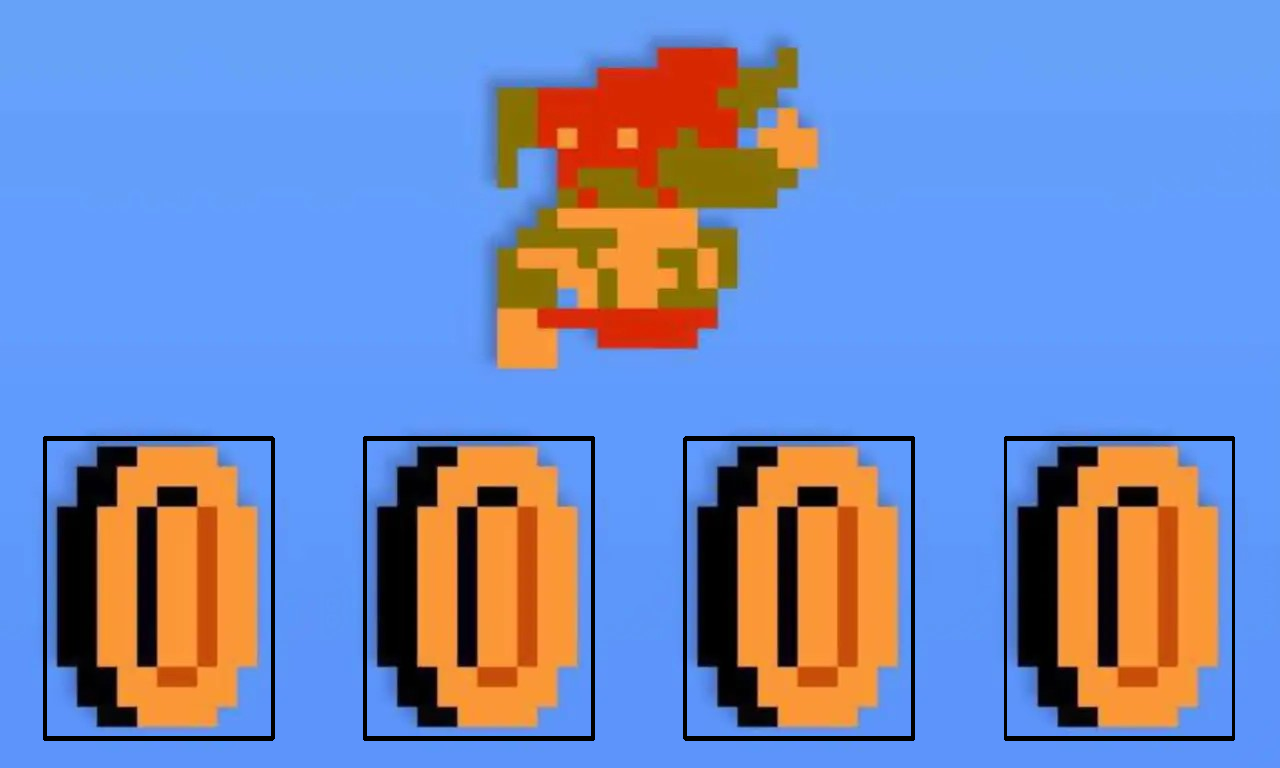

In [17]:
# Seaching for multiple instances of the template in the main image
res = cv2.matchTemplate(mg, rotatedt, cv2.TM_CCOEFF_NORMED)

# Store the coordinates of matched areas in a array
loc = np.where(res >= 0.99)

# Draw a rectangle around every matched region.
for pt in zip(*loc[::-1]):
    print(pt)
    cv2.rectangle(m, pt, (int((pt[0] + scaled_w)), int((pt[1] + scaled_h))), (0, 0, 0), 2)

# Show the final image with the matched areas.
cv2_imshow(m)